## Load from csv

In [1]:
import pandas as pd

In [3]:
X_train = pd.read_csv("new_split/X_train.csv")
y_train = pd.read_csv("new_split/y_train.csv")

X_val = pd.read_csv("new_split/X_val.csv")
y_val = pd.read_csv("new_split/y_val.csv")

X_test = pd.read_csv("new_split/X_test.csv")
y_test = pd.read_csv("new_split/y_test.csv")

In [4]:
X_train.head()

,YYYY,MM,DD,DOY,2m_temp_mean,2m_dp_temp_mean,10m_wind_u,10m_wind_v,fcst_alb,lai_high_veg,lai_low_veg,swe,surf_net_solar_rad_mean,surf_net_therm_rad_mean,surf_press,total_et,volsw_123,volsw_4,gauge_id,date
0,1981,1,1,1,-0.388068,-0.717942,3.559493,-0.889973,-0.260289,-1.309282,-1.722225,0.135370,-1.082294,0.399797,0.812397,-0.225572,0.387216,-0.525093,357,1981-01-01
1,1981,1,2,2,-0.670595,-0.825833,3.235187,-0.797101,-0.260289,-1.309282,-1.722225,0.135902,-1.054360,0.444297,0.831027,-0.411242,0.387216,-0.525093,357,1981-01-02
2,1981,1,3,3,-0.117313,-0.255054,4.662133,-0.239866,-0.337025,-1.309282,-1.722225,0.092856,-1.096261,-0.594534,0.600979,0.561086,0.387216,-0.525093,357,1981-01-03
3,1981,1,4,4,-0.376296,-0.437771,3.040604,-0.704228,-0.650615,-1.309282,-1.722225,-0.105046,-0.872787,0.798521,0.566626,-0.265150,0.546780,-0.525093,357,1981-01-04
4,1981,1,5,5,-0.882491,-1.037198,2.781159,-2.375932,-0.492468,-1.309282,-1.722225,-0.011466,-1.207998,0.399797,0.656355,-0.668830,0.546780,-0.525093,357,1981-01-05


In [5]:
X_train.columns

Index(['YYYY', 'MM', 'DD', 'DOY', '2m_temp_mean', '2m_dp_temp_mean',
       '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg',
       'swe', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_mean',
       'surf_press', 'total_et', 'volsw_123', 'volsw_4', 'gauge_id', 'date'],
      dtype='object')

### Creating dataset version with lags

In [6]:
lags = [1,3,7]

def add_local_lags(X_df,y_df,lags):
  df_temp = X_df.copy()
  df_temp['prec'] = y_df
  df_temp.sort_values(by = ['gauge_id','date'],inplace = True)
  for lag in lags:
    df_temp[f'prec_{lag}'] = df_temp.groupby('gauge_id')['prec'].shift(lag)
  df_temp.sort_values(by = ['date','gauge_id'],inplace = True)
  y_lagged = df_temp['prec']
  X_lagged = df_temp.drop(columns=['prec'])

  return X_lagged,y_lagged
X_train_lagged, y_train_lagged = add_local_lags(X_train, y_train, lags)
X_val_lagged, y_val_lagged = add_local_lags(X_val, y_val, lags)
X_test_lagged, y_test_lagged = add_local_lags(X_test, y_test,lags)

In [7]:
impute_cols = ["prec_1","prec_3","prec_7"]
train_local_medians = X_train_lagged.groupby('gauge_id')[impute_cols].median()
median_maps = {}
for col in impute_cols:
    median_maps[col] = train_local_medians[col].to_dict()

def impute_with_train_median(df,median_maps,gauge_id_col = 'gauge_id'):
    df_imputed = df.copy()
    for col, map_dict in median_maps.items():
        median_map_series = df_imputed[gauge_id_col].map(map_dict)

        df_imputed[col] = df_imputed[col].fillna(median_map_series)

    return df_imputed
X_train_lagged = impute_with_train_median(X_train_lagged, median_maps)


X_val_lagged = impute_with_train_median(X_val_lagged, median_maps)


X_test_lagged = impute_with_train_median(X_test_lagged, median_maps)

In [8]:
X_test_lagged.head()

,YYYY,MM,DD,DOY,2m_temp_mean,2m_dp_temp_mean,10m_wind_u,10m_wind_v,fcst_alb,lai_high_veg,...,surf_net_therm_rad_mean,surf_press,total_et,volsw_123,volsw_4,gauge_id,date,prec_1,prec_3,prec_7
2137,2014,2,24,55,-0.658823,-1.356478,-0.591623,0.874604,1.346513,0.238358,...,1.672162,-0.366896,-0.500580,-0.410607,0.008732,10,2014-02-24,1.43,1.43,1.430
83343,2014,2,24,55,-0.729455,-1.254394,-0.591623,0.688859,0.953939,-0.057147,...,1.845133,-0.203846,-0.444210,-0.091478,0.008732,27,2014-02-24,1.51,1.51,1.510
121809,2014,2,24,55,-1.753617,-2.063410,-0.461900,0.688859,2.374746,0.958921,...,1.411675,-2.089006,-1.280750,-0.570172,0.008732,66,2014-02-24,1.64,1.64,1.640
156001,2014,2,24,55,-1.659441,-1.738213,-0.267317,0.781731,2.431757,1.289040,...,0.666044,-2.434761,-1.390978,3.418943,4.457269,79,2014-02-24,1.30,1.30,1.295
132494,2014,2,24,55,-1.682985,-1.767993,-0.332178,0.874604,2.201537,0.958921,...,0.798521,-2.284187,-1.390978,0.706345,1.610205,80,2014-02-24,1.36,1.36,1.360


In [9]:
X_train_lagged.drop(['YYYY',"MM","DD","DOY","date","gauge_id"],axis = 1,inplace=True)
X_val_lagged.drop(['YYYY',"MM","DD","DOY","date","gauge_id"],axis = 1,inplace=True)
X_test_lagged.drop(['YYYY',"MM","DD","DOY","date","gauge_id"],axis = 1,inplace=True)

In [10]:
X_train.drop(['YYYY',"MM","DD","DOY","date","gauge_id"],axis = 1,inplace=True)
X_val.drop(['YYYY',"MM","DD","DOY","date","gauge_id"],axis = 1,inplace=True)
X_test.drop(['YYYY',"MM","DD","DOY","date","gauge_id"],axis = 1,inplace=True)

# Forecasting Models

## Helpers

### Train ARIMA

#### Define model

In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

y_train_series = y_train.copy()
y_val_series = y_val.copy()
y_test_series = y_test.copy()


arima_order = (1, 1, 1) # (p, d, q)

arima_model = ARIMA(y_train_series, order=arima_order)

#### Train

In [12]:
arima_model_fit = arima_model.fit()

#### Predict

In [13]:
y_pred_arima = arima_model_fit.predict(start=y_test_series.index[0], end=y_test_series.index[-1])


In [14]:
print(y_pred_arima)
print(y_train_series)
print(y_test_series)

0         0.000000
1         0.839988
2         1.574036
3         4.213358
4         1.913038
            ...   
213695    1.253711
213696    1.246056
213697    1.542146
213698    1.356998
213699    2.770323
Name: predicted_mean, Length: 213700, dtype: float64
         prec
0        0.84
1        1.97
2        6.51
3        1.02
4        3.09
...       ...
997095   0.77
997096   6.86
997097   5.09
997098  12.37
997099   7.16

[997100 rows x 1 columns]
        prec
0       0.00
1       0.00
2       0.00
3       0.00
4       0.23
...      ...
213695  2.04
213696  0.02
213697  0.00
213698  0.00
213699  0.00

[213700 rows x 1 columns]


### Evaluation helpers

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import json
import datetime

# --- 1. SETUP: ASSUME THESE VARIABLES EXIST ---
# y_test: The true target values (e.g., a NumPy array of shape (N, 1) or (N,))
# y_pred: The predicted values from model.predict(X_test_seq) (shape should match y_test)
# ----------------------------------------------
def generate_predictions_sequence(original_y_test_series, look_back = 0, prev_steps = 0):
    """
    Generates naive (t-1) predictions for sequence models.
    For a target y_t, the prediction is y_{t-1}.
    This aligns with how y_test_seq is created from original_y_test_series.
    """
    # y_test_seq was created from original_y_test_series.iloc[look_back:]
    # For y_test_seq[i] (which is original_y_test_series.iloc[look_back + i]),
    # the t-1 prediction is original_y_test_series.iloc[look_back + i - 1].
    # This corresponds to slicing the original series from (look_back - 1) up to (but not including) the last element.
    naive_preds = original_y_test_series.iloc[look_back - prev_steps : len(original_y_test_series) - prev_steps]
    return naive_preds.values

def evaluate(y_pred, y_test, prefix="model", results_dir='results', plot = False):
  # --- 2. CALCULATE NUMERICAL METRICS ---
  print(f"--- Numerical Regression Metrics ({prefix}) ---")

  # Ensure both are flattened to 1D arrays for scikit-learn metrics
  y_test_flat = np.array(y_test).flatten()
  y_pred_flat = np.array(y_pred).flatten()

  # Mean Squared Error (MSE)
  mse = mean_squared_error(y_test_flat, y_pred_flat)

  # Root Mean Squared Error (RMSE) - The most interpretable error metric
  rmse = np.sqrt(mse)

  # Mean Absolute Error (MAE) - Robust to outliers
  mae = mean_absolute_error(y_test_flat, y_pred_flat)

  # R-squared (R2) Score - Goodness of fit (closer to 1.0 is better)
  r2 = r2_score(y_test_flat, y_pred_flat)

  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"R-squared Score (R2): {r2:.4f}")
  print("-" * 40)

  # Save numerical metrics to JSON
  metrics = {
      "mse": mse,
      "rmse": rmse,
      "mae": mae,
      "r2": r2
  }
  timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
  json_filename = os.path.join(results_dir, f"evaluation_metrics_{prefix}_{timestamp}.json")
  with open(json_filename, 'w') as f:
      json.dump(metrics, f, indent=4)
  print(f"Numerical metrics saved to {json_filename}")


  if plot:
    # --- 3. VISUAL ANALYSIS: Plot True vs. Predicted ---
    # This plot is essential for time series to see if the model captures trends
    plt.figure(figsize=(12, 6))

    # Plot the true values
    plt.plot(y_test_flat, label='True Values', color='blue', linewidth=0.5)

    # Plot the predicted values
    plt.plot(y_pred_flat, label='Predicted Values', color='red', linestyle='--', linewidth=0.5)

    plt.title(f'True vs. Predicted Values (RMSE: {rmse:.4f}) ({prefix})')
    plt.xlabel('Time Step / Sample Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    # Save the figure
    plot1_filename = os.path.join(results_dir, f"true_vs_predicted_{prefix}_{timestamp}.png")
    plt.savefig(plot1_filename)
    plt.show() # Display the plot
    print(f"True vs. Predicted plot saved to {plot1_filename}")
    plt.close() # Close the figure to free up memory


    # --- 4. VISUAL ANALYSIS: Plot Residuals ---
    # Residuals = Error = True - Predicted. They should be centered around zero.
    residuals = y_test_flat - y_pred_flat

    plt.figure(figsize=(12, 3))
    plt.plot(residuals, label='Residuals (Error)', color='green', linewidth=0.5)
    plt.axhline(0, color='red', linestyle='-') # Line at zero
    plt.title(f'Residual Plot (Errors Over Time) ({prefix})')
    plt.xlabel('Time Step / Sample Index')
    plt.ylabel('Residual Value (True - Predicted)')
    plt.legend()
    plt.grid(True)
    # Save the figure
    plot2_filename = os.path.join(results_dir, f"residuals_plot_{prefix}_{timestamp}.png")
    plt.savefig(plot2_filename)
    plt.show() # Display the plot
    print(f"Residuals plot saved to {plot2_filename}")
    plt.close() # Close the figure to free up memory

  return metrics


def compare_model_with_baselines(model_name, y_pred_model, y_test_target, y_pred_naive_baseline, y_pred_arima_baseline):
    """
    Evaluates a model's predictions and compares them against naive (t-1) and ARIMA baselines.

    Args:
        model_name (str): Name of the model being evaluated (e.g., 'LSTM', 'XGBoost').
        y_pred_model (np.ndarray): Predictions from the actual model (already inverse-transformed if necessary).
        y_test_target (np.ndarray): True target values corresponding to y_pred_model (already inverse-transformed if necessary).
        y_pred_naive_baseline (np.ndarray): Pre-computed naive (t-1) predictions (already inverse-transformed).
        y_pred_arima_baseline (np.ndarray): Pre-computed ARIMA predictions (already inverse-transformed).
    """
    # Create results directory
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True) # Ensure directory exists

    print(f"--- Evaluation for {model_name} ---")
    model_metrics = evaluate(y_pred_model, y_test_target, prefix=model_name.replace(' ', '_').lower(), results_dir=results_dir, plot=True)

    print(f"\n--- Comparing {model_name} with Baselines ---")

    print("--- Naive (t-1) Baseline Evaluation ---")
    naive_metrics = evaluate(y_pred_naive_baseline, y_test_target, prefix="naive_baseline", results_dir=results_dir)

    print("--- ARIMA Baseline Evaluation ---")
    arima_metrics = evaluate(y_pred_arima_baseline, y_test_target, prefix="arima_baseline", results_dir=results_dir, plot=True)

    # 2. Create a list of these metric dictionaries
    metrics_list = [model_metrics, arima_metrics, naive_metrics]

    # 4. Create a pandas DataFrame from the list of dictionaries
    metrics_df = pd.DataFrame(metrics_list)

    # 5. Add a new column named 'Model' to the DataFrame
    metrics_df['Model'] = [model_name, 'ARIMA', 'naive (t-1)']

    # Reorder columns to have 'Model' first for better readability
    metrics_df = metrics_df[['Model', 'mse', 'rmse', 'mae', 'r2']]
    metrics_df.transpose()

    print("\n--- Overall Performance Comparison ---")
    print(metrics_df.to_string(index=False))
    print("-" * 50)

    metrics_filename = os.path.join(results_dir, f"{model_name}_evaluation_metrics.csv")
    metrics_df.to_csv(f"metrics_{model_name.replace(' ', '_').lower()}.csv", index=False)
    print(f"{model_name} evaluation metrics saved to {metrics_filename}")


## Model fine tuning

### Training

In [16]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib
import os

param_grid = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2], 
    'colsample_bytree': [0.7, 1.0], 
    'subsample': [0.7, 1.0]         
}

base_xgb = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,

    objective='reg:squarederror'
)

grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    return_train_score=True
)

print("Starting Grid Search...")
grid_search.fit(X_train_lagged, y_train_lagged)

print("Grid Search Complete.")

Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=(train=-20.751, test=-21.058) total time=   5.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=(train=-20.965, test=-19.969) total time=   4.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=(train=-20.951, test=-20.003) total time=   6.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=(train=-20.058, test=-24.411) total time=   8.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=(train=-21.298, test=-18.959) total time=   7.1s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=(train=-20.759, test

In [17]:
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_ 
y_pred_val = best_xgb_model.predict(X_val_lagged)
val_mse = mean_squared_error(y_val_lagged, y_pred_val)
print(f"MSE on Validation Set: {val_mse}")

# Optional: Evaluate the best model on your held-out test set (if available)
# y_pred_test = best_xgb_model.predict(X_test_lagged)
# test_mse = mean_squared_error(y_test_lagged, y_pred_test)
# print(f"MSE on Test Set: {test_mse}")

MSE on Validation Set: 10.256603222968499


In [18]:
model_filename = 'xgboost_prec_model_tuned.joblib'
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True) 

save_path = os.path.join(model_dir, model_filename)

joblib.dump(best_xgb_model, save_path)


['saved_models\\xgboost_prec_model_tuned.joblib']

#### Evaluate

In [19]:
target_index = y_test_lagged.index
y_arima_aligned = y_pred_arima.reindex(target_index)
arima_fallback_value = y_train_lagged.median() 
y_arima_aligned.fillna(arima_fallback_value, inplace=True)
y_arima_baseline = y_arima_aligned.values


In [20]:

y_pred_xgb = best_xgb_model.predict(X_test_lagged)


--- Evaluation for XGBoost Regressor ---
--- Numerical Regression Metrics (xgboost_regressor) ---
Mean Squared Error (MSE): 9.4080
Root Mean Squared Error (RMSE): 3.0672
Mean Absolute Error (MAE): 1.6847
R-squared Score (R2): 0.6990
----------------------------------------
Numerical metrics saved to results\evaluation_metrics_xgboost_regressor_20251215_124138.json


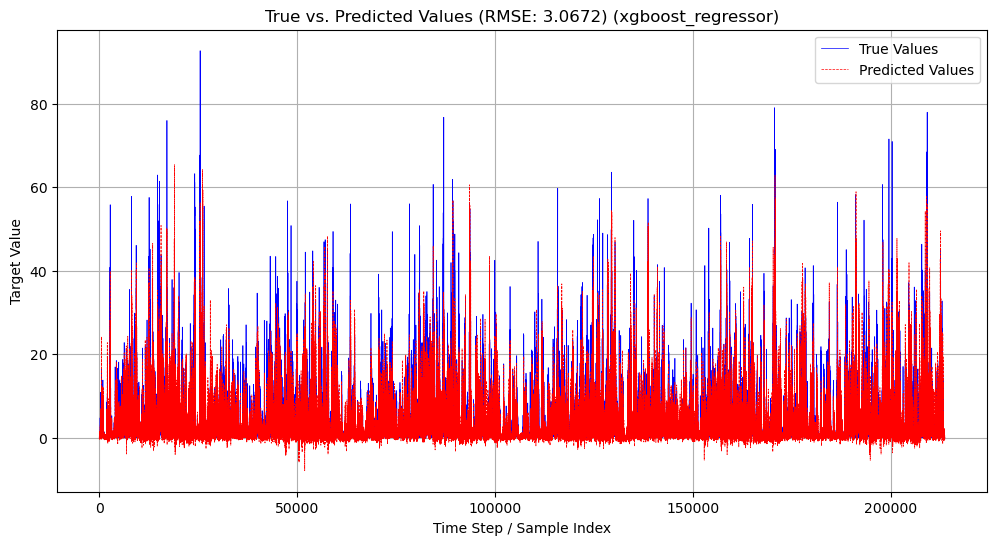

True vs. Predicted plot saved to results\true_vs_predicted_xgboost_regressor_20251215_124138.png


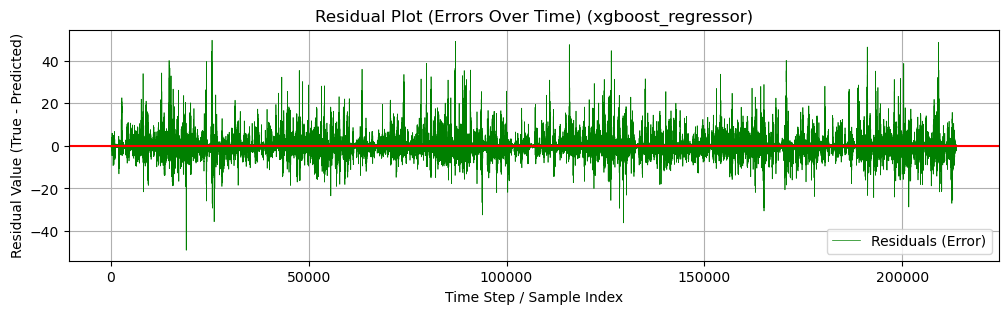

Residuals plot saved to results\residuals_plot_xgboost_regressor_20251215_124138.png

--- Comparing XGBoost Regressor with Baselines ---
--- Naive (t-1) Baseline Evaluation ---
--- Numerical Regression Metrics (naive_baseline) ---
Mean Squared Error (MSE): 42.1920
Root Mean Squared Error (RMSE): 6.4955
Mean Absolute Error (MAE): 3.6397
R-squared Score (R2): -0.3501
----------------------------------------
Numerical metrics saved to results\evaluation_metrics_naive_baseline_20251215_124142.json
--- ARIMA Baseline Evaluation ---
--- Numerical Regression Metrics (arima_baseline) ---
Mean Squared Error (MSE): 35.7988
Root Mean Squared Error (RMSE): 5.9832
Mean Absolute Error (MAE): 3.9353
R-squared Score (R2): -0.1455
----------------------------------------
Numerical metrics saved to results\evaluation_metrics_arima_baseline_20251215_124142.json


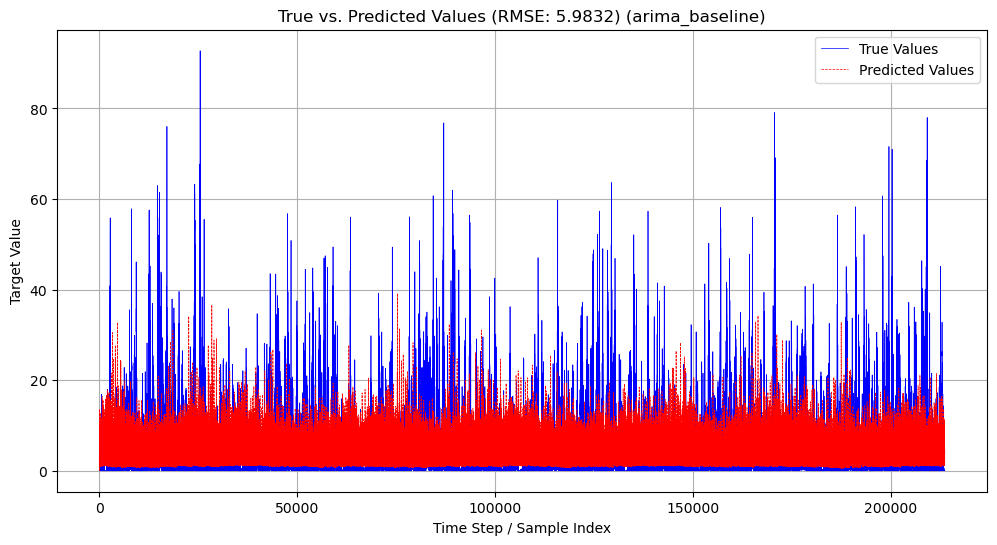

True vs. Predicted plot saved to results\true_vs_predicted_arima_baseline_20251215_124142.png


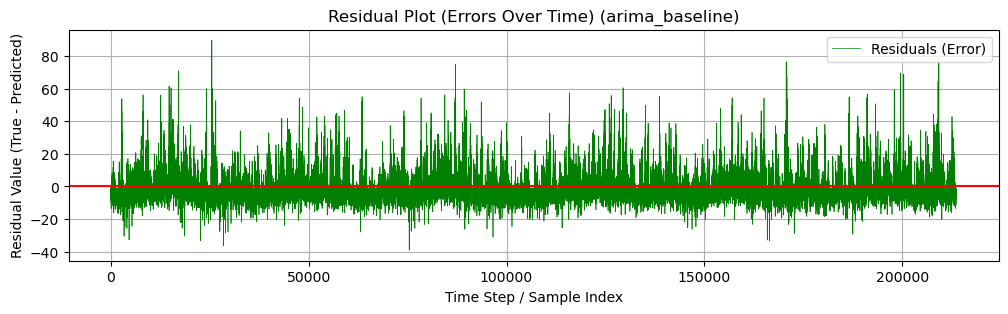

Residuals plot saved to results\residuals_plot_arima_baseline_20251215_124142.png

--- Overall Performance Comparison ---
            Model       mse     rmse      mae        r2
XGBoost Regressor  9.407965 3.067241 1.684660  0.698953
            ARIMA 35.798791 5.983209 3.935344 -0.145531
      naive (t-1) 42.192001 6.495537 3.639684 -0.350108
--------------------------------------------------
XGBoost Regressor evaluation metrics saved to results\XGBoost Regressor_evaluation_metrics.csv


In [22]:

compare_model_with_baselines("XGBoost Regressor", y_pred_xgb, y_test_lagged, X_test_lagged['prec_1'].values, y_arima_baseline)

## Feature Importance

Loaded model successfully from: saved_models\xgboost_prec_model_tuned.joblib

--- Top 10 Features by GAIN ---
                    Feature         Gain
9   surf_net_therm_rad_mean  4111.103516
11                 total_et  2758.906494
14                   prec_1  1692.335938
8   surf_net_solar_rad_mean  1022.276855
10               surf_press   850.566101
5              lai_high_veg   814.026428
1           2m_dp_temp_mean   740.578125
2                10m_wind_u   642.406616
7                       swe   514.312744
0              2m_temp_mean   447.102814
6               lai_low_veg   401.572449
4                  fcst_alb   398.667572
13                  volsw_4   384.423431
3                10m_wind_v   367.778595
16                   prec_7   304.711823
15                   prec_3   259.098053
12                volsw_123   258.765564


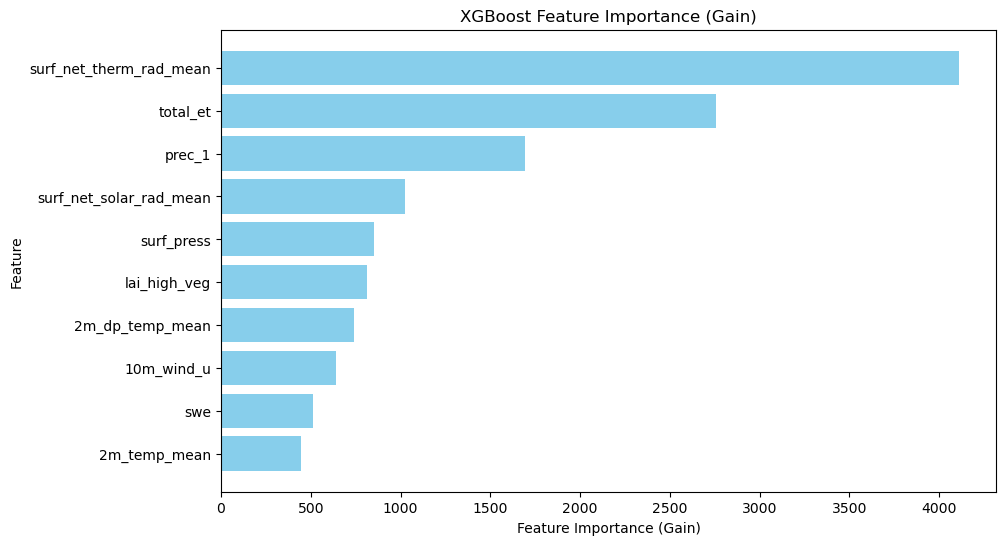

In [25]:
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt

# --- 1. Load the Best Model ---
model_filename = 'xgboost_prec_model_tuned.joblib'
model_dir = 'saved_models'
load_path = os.path.join(model_dir, model_filename)

try:
    best_xgb_model = joblib.load(load_path)
    print(f"Loaded model successfully from: {load_path}")
except FileNotFoundError:
    print("Error: Model file not found. Ensure you ran the previous saving step.")
    


importance_gain = best_xgb_model.get_booster().get_score(importance_type='gain')


importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Gain': list(importance_gain.values())
})


importance_df = importance_df.sort_values(by='Gain', ascending=False)

print("\n--- Top 10 Features by GAIN ---")
print(importance_df.head(20))


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Gain'].head(10), color='skyblue')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (Gain)')
plt.gca().invert_yaxis() # Put the most important feature at the top
plt.show()

In [24]:
print(best_params)

{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
